In [1]:
'''
Plot exetent/area from observations and models (past and future)
'''

%matplotlib inline
%load_ext autoreload
%autoreload
import matplotlib
import matplotlib.pyplot as plt, mpld3
from collections import OrderedDict
import itertools
import numpy as np
import numpy.ma as ma
import pandas as pd
import struct
import os
import xarray as xr
import glob
import datetime
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
np.seterr(divide='ignore', invalid='ignore')

import esio
import esiodata as ed

# General plotting settings
sns.set_style('whitegrid')
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [2]:
#############################################################
# Load in Data
#############################################################
E = ed.esiodata.load()

ds_81 = xr.open_mfdataset(E.obs['NSIDC_0081']['sipn_nc']+'/*.nc', concat_dim='time', autoclose=True)

ds_ext = xr.open_dataset(os.path.join(E.obs['NSIDC_extent']['sipn_nc'], 'N_seaice_extent_daily_v3.0.nc'))
ds_ext = ds_ext.rename({'datetime':'time'})

In [3]:
# Load in regional data
# Note minor -0.000004 degree differences in latitude
ds_region = xr.open_dataset(os.path.join(E.grid_dir, 'sio_2016_mask.nc'))
ds_region.set_coords(['lat','lon'], inplace=True);
ds_region.rename({'nx':'x', 'ny':'y'}, inplace=True);

In [4]:
model='ukmetofficesipn'

In [5]:
ds_mod = xr.open_dataset('/home/disk/sipn/nicway/data/model/'+model+'/forecast/sipn_nc/'+model+'_2018_03_Stereo.nc')
ds_mod = ds_mod.isel(ensemble=0).isel(init_time=0).isel(fore_time=0).sic
ds_mod = ds_mod.rename({'nj':'x','ni':'y'})

In [6]:
fig_dir = os.path.join(E.fig_dir, 'model', 'extent_test')

In [7]:
mod_ext = ((ds_mod >= 0.15).astype('int') * ds_region.area).sum(dim='x').sum(dim='y')/(10**6)

In [8]:
# Obs
p_obs = (ds_81.sic.sel(time=ds_mod.init_time.values, method='nearest') >=0.15 ).where(ds_81.sic.sel(time=ds_mod.init_time.values, method='nearest').notnull())
obs_ext = ((p_obs * ds_region.area).sum(dim='x').sum(dim='y')/(10**6)).load()
obs_ext_Offical = ds_ext.sel(time=ds_mod.init_time.values, method='nearest')

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


Text(0.5,1,'Observed. \nCalc Extent:14.6\nOffical Extent:14.4')

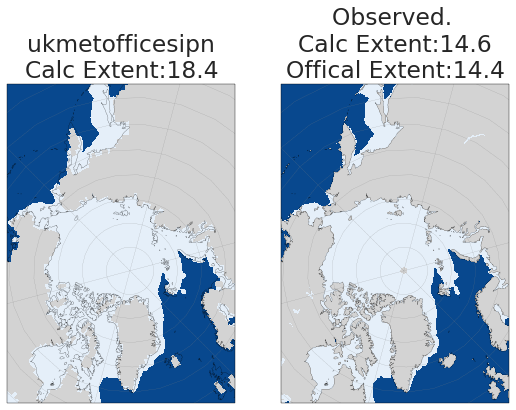

In [9]:
# Plot map at fore_time 0
cmap_c = matplotlib.colors.ListedColormap(sns.color_palette("Blues_r", 10))
cmap_c.set_bad(color = 'lightgrey')
c_label = 'Sea Ice Concentration (-)'
c_vmin = 0
c_vmax = 1
(f, axes) = esio.multi_polar_axis(ncols=2, nrows=1, Nplots=3, sizefcter=3)
p = (ds_mod >= 0.15).where(ds_mod.notnull()).plot.pcolormesh(ax=axes[0], x='lon', y='lat', 
                                      transform=ccrs.PlateCarree(),
                                      add_colorbar=False,
                                      cmap=cmap_c,
                                      vmin=c_vmin, vmax=c_vmax)
# Calc extents
axes[0].set_title(model+'\nCalc Extent:'+'{0:.1f}'.format(mod_ext.values))

p = p_obs.plot.pcolormesh(ax=axes[1], x='lon', y='lat', 
                                      transform=ccrs.PlateCarree(),
                                      add_colorbar=False,
                                      cmap=cmap_c,
                                      vmin=c_vmin, vmax=c_vmax)
axes[1].set_title('Observed. \nCalc Extent:'+'{0:.1f}'.format(obs_ext.values)+'\n'+
                 'Offical Extent:'+'{0:.1f}'.format(obs_ext_Offical.Extent.values))



In [10]:
f.savefig(os.path.join(fig_dir, model+'_example.png'))